<a href="https://colab.research.google.com/github/sowmen/Deepfake-Challenge-Kaggle/blob/master/Original_CVPRW2019_Face_Artifacts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!git clone 'https://github.com/danmohaha/CVPRW2019_Face_Artifacts.git'

Cloning into 'CVPRW2019_Face_Artifacts'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 73.19 MiB | 36.88 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [0]:
!pip install -U opencv-python==3.4.9.31

     |████████████████████████████████| 28.2MB 82kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [0]:
import sys, os
sys.path.insert(1,'CVPRW2019_Face_Artifacts/' )

In [0]:
import tensorflow as tf
from resolution_network import ResoNet
from solver import Solver
from easydict import EasyDict as edict
import cv2, yaml, os, dlib
from py_utils.vis import vis_im
import numpy as np
from py_utils.face_utils import lib
from py_utils.vid_utils import proc_vid as pv
import logging
import time
import matplotlib.pyplot as plt
import math
import random


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
print(tf.__version__)
print(cv2.__version__)

1.15.0
3.4.9


In [0]:
test_dir = "drive/My Drive/test2/"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

22

In [0]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

def load_mobilenetv2_224_075_detector(path):
    input_tensor = Input(shape=(224, 224, 3))
    output_tensor = MobileNetV2(weights=None, include_top=False, input_tensor=input_tensor, alpha=0.75).output
    output_tensor = ZeroPadding2D()(output_tensor)
    output_tensor = Conv2D(kernel_size=(3, 3), filters=5)(output_tensor)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.load_weights(path)
    
    return model

mobilenetv2 = load_mobilenetv2_224_075_detector("drive/My Drive/YoloV2/facedetection-mobilenetv2-size224-alpha0.75.h5")

In [0]:
# Converts A:B aspect rate to B:A
def transpose_shots(shots):
    return [(shot[1], shot[0], shot[3], shot[2], shot[4]) for shot in shots]

#That constant describe pieces for 16:9 images
SHOTS = {
    # fast less accurate
    '2-16/9' : {
        'aspect_ratio' : 16/9,
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1)
        ]
    },
    # slower more accurate
    '10-16/9' : {
        'aspect_ratio' : 16/9,
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1),
             (0, 0, 5/16, 5/9, 0.5),
             (0, 4/9, 5/16, 5/9, 0.5),
             (11/48, 0, 5/16, 5/9, 0.5),
             (11/48, 4/9, 5/16, 5/9, 0.5),
             (22/48, 0, 5/16, 5/9, 0.5),
             (22/48, 4/9, 5/16, 5/9, 0.5),
             (11/16, 0, 5/16, 5/9, 0.5),
             (11/16, 4/9, 5/16, 5/9, 0.5),
        ]
    }
}

# 9:16 respectively
SHOTS_T = {
    '2-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['2-16/9']['shots'])
    },
    '10-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['10-16/9']['shots'])
    }
}

def r(x):
    return int(round(x))

def sigmoid(x):
    return 1 / (np.exp(-x) + 1)

def non_max_suppression(boxes, p, iou_threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort(p)
    true_boxes_indexes = []

    while len(indexes) > 0:
        true_boxes_indexes.append(indexes[-1])

        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        iou = intersection / ((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]) + (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]) - intersection)

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, np.where(iou >= iou_threshold)[0])

    return boxes[true_boxes_indexes]

def union_suppression(boxes, threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort((x2 - x1) * (y2 - y1))
    result_boxes = []

    while len(indexes) > 0:
        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        min_s = np.minimum((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]), (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]))
        ioms = intersection / (min_s + 1e-9)
        neighbours = np.where(ioms >= threshold)[0]
        if len(neighbours) > 0:
            result_boxes.append([min(np.min(x1[indexes[neighbours]]), x1[indexes[-1]]), min(np.min(y1[indexes[neighbours]]), y1[indexes[-1]]), max(np.max(x2[indexes[neighbours]]), x2[indexes[-1]]), max(np.max(y2[indexes[neighbours]]), y2[indexes[-1]])])
        else:
            result_boxes.append([x1[indexes[-1]], y1[indexes[-1]], x2[indexes[-1]], y2[indexes[-1]]])

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, neighbours)

    return result_boxes

class FaceDetector():
    """
    That's API you can easily use to detect faces
    
    __init__ parameters:
    -------------------------------
    model - model to infer
    shots - list of aspect ratios that images could be (described earlier)
    image_size - model's input size (hardcoded for mobilenetv2)
    grids - model's output size (hardcoded for mobilenetv2)
    union_threshold - threshold for union of predicted boxes within multiple shots
    iou_threshold - IOU threshold for non maximum suppression used to merge YOLO detected boxes for one shot,
                    you do need to change this because there are one face per image as I can see from the samples
    prob_threshold - probability threshold for YOLO algorithm, you can balance beetween precision and recall using this threshold
    
    detect parameters:
    -------------------------------
    frame - (1920, 1080, 3) or (1080, 1920, 3) RGB Image
    returns: list of 4 element tuples (left corner x, left corner y, right corner x, right corner y) of detected boxes within [0, 1] range (see box draw code below)
    """
    def __init__(self, model=mobilenetv2, shots=[SHOTS['10-16/9'], SHOTS_T['10-9/16']], image_size=224, grids=7, iou_threshold=0.1, union_threshold=0.1):
        self.model = model
        self.shots = shots
        self.image_size = image_size
        self.grids = grids
        self.iou_threshold = iou_threshold
        self.union_threshold = union_threshold
        self.prob_threshold = 0.7
        
    
    def detect(self, frame, threshold = 0.7):
        original_frame_shape = frame.shape
        self.prob_threshold = threshold
        aspect_ratio = None
        for shot in self.shots:
            if abs(frame.shape[1] / frame.shape[0] - shot["aspect_ratio"]) < 1e-9:
                aspect_ratio = shot["aspect_ratio"]
                shots = shot
        
        assert aspect_ratio is not None
        
        c = min(frame.shape[0], frame.shape[1] / aspect_ratio)
        slice_h_shift = r((frame.shape[0] - c) / 2)
        slice_w_shift = r((frame.shape[1] - c * aspect_ratio) / 2)
        if slice_w_shift != 0 and slice_h_shift == 0:
            frame = frame[:, slice_w_shift:-slice_w_shift]
        elif slice_w_shift == 0 and slice_h_shift != 0:
            frame = frame[slice_h_shift:-slice_h_shift, :]

        frames = []
        for s in shots["shots"]:
            frames.append(cv2.resize(frame[r(s[1] * frame.shape[0]):r((s[1] + s[3]) * frame.shape[0]), r(s[0] * frame.shape[1]):r((s[0] + s[2]) * frame.shape[1])], (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST))
        frames = np.array(frames)

        predictions = self.model.predict(frames, batch_size=len(frames), verbose=0)

        boxes = []
        prob = []
        shots = shots['shots']
        for i in range(len(shots)):
            slice_boxes = []
            slice_prob = []
            for j in range(predictions.shape[1]):
                for k in range(predictions.shape[2]):
                    p = sigmoid(predictions[i][j][k][4])
                    if not(p is None) and p > self.prob_threshold:
                        px = sigmoid(predictions[i][j][k][0])
                        py = sigmoid(predictions[i][j][k][1])
                        pw = min(math.exp(predictions[i][j][k][2] / self.grids), self.grids)
                        ph = min(math.exp(predictions[i][j][k][3] / self.grids), self.grids)
                        if not(px is None) and not(py is None) and not(pw is None) and not(ph is None) and pw > 1e-9 and ph > 1e-9:
                            cx = (px + j) / self.grids
                            cy = (py + k) / self.grids
                            wx = pw / self.grids
                            wy = ph / self.grids
                            if wx <= shots[i][4] and wy <= shots[i][4]:
                                lx = min(max(cx - wx / 2, 0), 1)
                                ly = min(max(cy - wy / 2, 0), 1)
                                rx = min(max(cx + wx / 2, 0), 1)
                                ry = min(max(cy + wy / 2, 0), 1)

                                lx *= shots[i][2]
                                ly *= shots[i][3]
                                rx *= shots[i][2]
                                ry *= shots[i][3]

                                lx += shots[i][0]
                                ly += shots[i][1]
                                rx += shots[i][0]
                                ry += shots[i][1]

                                slice_boxes.append([lx, ly, rx, ry])
                                slice_prob.append(p)

            slice_boxes = np.array(slice_boxes)
            slice_prob = np.array(slice_prob)

            slice_boxes = non_max_suppression(slice_boxes, slice_prob, self.iou_threshold)

            for sb in slice_boxes:
                boxes.append(sb)


        boxes = np.array(boxes)
        boxes = union_suppression(boxes, self.union_threshold)

        for i in range(len(boxes)):
            boxes[i][0] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][1] /= original_frame_shape[0] / frame.shape[0]
            boxes[i][2] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][3] /= original_frame_shape[0] / frame.shape[0]

            boxes[i][0] += slice_w_shift / original_frame_shape[1]
            boxes[i][1] += slice_h_shift / original_frame_shape[0]
            boxes[i][2] += slice_w_shift / original_frame_shape[1]
            boxes[i][3] += slice_h_shift / original_frame_shape[0]

        return list(boxes)

In [0]:
def get_boxes_points(boxes, frame_shape):
    result = []
    for box in boxes:
        lx = int(round(box[0] * frame_shape[1]))
        ly = int(round(box[1] * frame_shape[0]))
        rx = int(round(box[2] * frame_shape[1]))
        ry = int(round(box[3] * frame_shape[0]))
        result.append((lx, ly, rx, ry))
    return result 

In [0]:
yolo_model = FaceDetector()

Load model weight and Face Detector weights.
Face Detector is **dlib**

In [0]:
cfg_file = 'CVPRW2019_Face_Artifacts/cfgs/res50.yml'
with open(cfg_file, 'r') as f:
    cfg = edict(yaml.load(f))
sample_num = 10

print(cfg)

front_face_detector = dlib.get_frontal_face_detector()
lmark_predictor = dlib.shape_predictor('CVPRW2019_Face_Artifacts/dlib_model/shape_predictor_68_face_landmarks.dat')

tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth=True
# init session
sess = tf.Session(config=tfconfig)
# Build network
reso_net = ResoNet(cfg=cfg, is_train=False)
reso_net.build()
# Build solver
solver = Solver(sess=sess, cfg=cfg, net=reso_net)
solver.init()

{'BASE_NETWORK': 'res50', 'PRETRAINED_MODELS': '', 'IMG_SIZE': [224, 224, 3], 'PIXEL_MEAN': [103.939, 116.779, 123.68], 'NUM_CLASSES': 2, 'BKG_LABEL': 0, 'CLASS_WEIGHTS': 1, 'SUMMARY_DIR': 'summary', 'MODEL_DIR_PREFIX': 'ckpt', 'MODEL_NAME': 'model', 'TRAIN': {'LEARNING_RATE': 0.001, 'DECAY_RATE': 0.95, 'NUM_EPOCH': 20, 'BETA': 0.001, 'BATCH_SIZE': 64, 'NEG_HARD_MINING': 1.0, 'POS_HARD_MINING': 1.0}, 'TEST': {'BATCH_SIZE': 8}}

Instructions for updating:
Please use `layer.__call__` method instead.



INFO:tensorflow:Restoring parameters from /content/CVPRW2019_Face_Artifacts/ckpt_res50/model
Loading checkpoint /content/CVPRW2019_Face_Artifacts/ckpt_res50/model


In [0]:
def im_test(im):
    print("===== START SINGLE FRAME ===")
    start_im = time.time()

    face_info = lib.align(im[:, :, (2,1,0)], front_face_detector, lmark_predictor)
    print("LENGTH - ", len(face_info))

    # Samples
    if len(face_info) == 0:
        logging.warning('No faces are detected.')
        prob = -1  # we ignore this case
    else:
        # Check how many faces in an image
        logging.info('{} faces are detected.'.format(len(face_info)))
        max_prob = -1
        face_count = 0
        # If one face is fake, the image is fake
        for _, point in face_info:
            rois = []
            for i in range(sample_num):
                roi, _ = lib.cut_head([im], point, i)
                rois.append(cv2.resize(roi[0], tuple(cfg.IMG_SIZE[:2])))

            vis_im(rois, 'vis{}.jpg'.format(face_count))
            face_count += 1

            for i in rois:
                plt.figure()
                plt.imshow(i)
                plt.show()
            print(rois[0].shape)

            prob = solver.test(rois)
            prob = np.mean(np.sort(prob[:, 0])[np.round(sample_num / 2).astype(int):])
            if prob >= max_prob:
                max_prob = prob
        prob = max_prob

    end_im = time.time() - start_im
    print("Single Frame time %f sec" % (end_im))

    return prob


def run(input_dir):
    logging.basicConfig(filename='run.log', filemode='w', format='[%(asctime)s - %(levelname)s] %(message)s',
                        level=logging.INFO)

    f_list = os.listdir(input_dir)
    prob_list = []
    for f_name in f_list:
        start_time = time.time()
        # Parse video
        f_path = os.path.join(input_dir, f_name)
        print('Testing: ' + f_path)
        logging.info('Testing: ' + f_path)
        suffix = f_path.split('.')[-1]
        if suffix.lower() in ['jpg', 'png', 'jpeg', 'bmp', 'tif', 'nef', 'raf']:
            im = cv2.imread(f_path)
            if im is None:
                prob = -1
            else:
                prob = im_test(im)

        elif suffix.lower() in ['mp4', 'avi', 'mov']:
            # Parse video
            imgs, frame_num, fps, width, height = pv.parse_vid(f_path)
            probs = []
            for fid, im in enumerate(imgs):
                logging.info('Frame ' + str(fid))
                prob = im_test(im)
                if prob == -1:
                    continue
                probs.append(prob)

            # Remove opt out frames
            if probs is []:
                prob = -1
            else:
                prob = np.mean(sorted(probs, reverse=True)[:int(frame_num / 3)])

        logging.info('Prob = ' + str(prob))
        prob_list.append(prob)
        print('Prob: ' + str(prob))
        elapsed = time.time() - start_time
        print("Elapsed %f sec" % (elapsed))

    sess.close()
    return prob_list

===== START SINGLE FRAME ===
LENGTH -  1


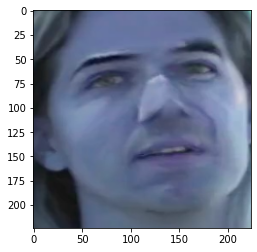

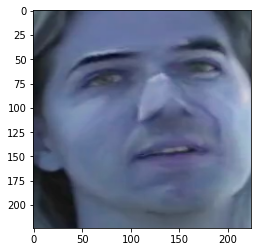

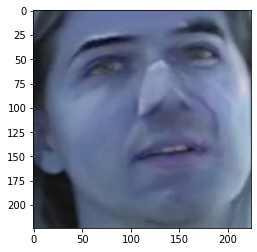

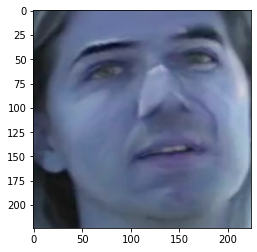

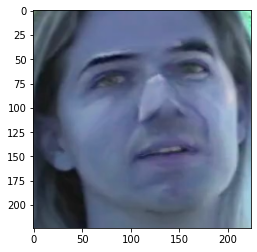

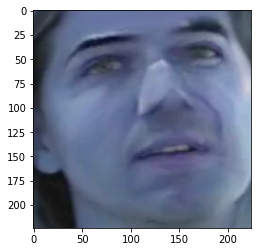

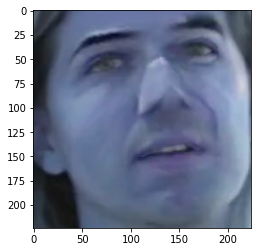

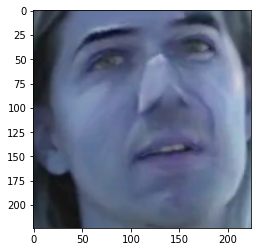

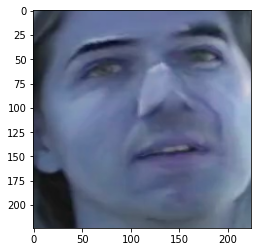

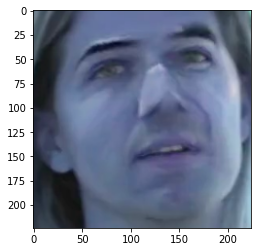

(224, 224, 3)
Single Frame time 2.186376 sec
0.3075481


In [0]:
image = cv2.imread("00001.jpg")
res = im_test(image)
print(res)

In [0]:
result = run(test_dir)

In [0]:
run("drive/My Drive/test2")